In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


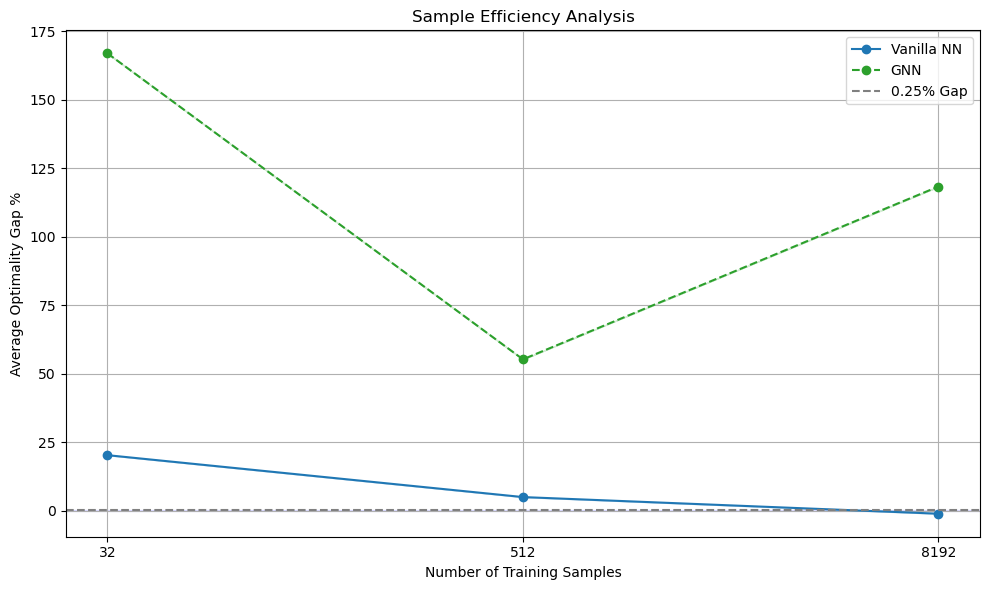

In [11]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_serial"

# Get optimal loss from echelon stock results
echelon_path = f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard'

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'samples':
        return 1
    if condition_name == 'dev_periods':
        return 50
    return None

# Get optimal loss from echelon stock with large sample size
optimal_df = results_interpretor.make_table({1: echelon_path},
    {'store_lead_time': 4,
     'store_underage_cost': 19,
     'train_dev_sample_and_batch_size': 32768},
    default_condition_setter, custom_data_filler,
    sort_by='dev_loss', pick_row_from_run_by='dev_loss',
    test_loss_limit = 1000)

optimal_loss = []
row = {
    'store_lead_time': 4,
    'store_underage_cost': 19,
    'Architecture Class': 'Optimal Loss',
    'Test Loss': optimal_df['Test Loss'].iloc[0]
}
optimal_loss.append(row)

echelon_df = pd.DataFrame(optimal_loss)
dfs = [echelon_df]

# Define color scheme for architectures
color_scheme = {
    "Vanilla NN": "#1f77b4",  # Blue
    "GNN": "#2ca02c",  # Green
}

linestyle_scheme = {
    "Vanilla NN": "-",  # Solid
    "GNN": "--",  # Dashed
}

# Define paths for each architecture
architectures = {
    "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
# Create dataframes for each architecture and parameter combination
params = {
    'store_lead_time': [4],
    'store_underage_cost': [19]
}
# Define sample sizes from 16 to 1024
sample_sizes = [32, 512, 8192]

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'store_lead_time': lead_time,
                     'store_underage_cost': underage_cost,
                     'train_dev_sample_and_batch_size': [sample_size],
                     'dev_periods': [100],
                     'samples': [1]},
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                    test_loss_limit = 100)
                if df.empty:
                    continue
                
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['store_lead_time'] = lead_time
                df['store_underage_cost'] = underage_cost
                df['train_dev_sample_and_batch_size'] = sample_size
                dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate optimality gap percentage using optimal loss values but exclude optimal loss from plotting
optimal_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Optimality Gap %'] = ((df['Test Loss'] - optimal_test_loss) / optimal_test_loss) * 100

# Calculate mean and confidence intervals for each sample size and architecture
stats_by_arch_and_sample = {}
for arch in df['Architecture Class'].unique():
    if arch == 'Optimal Loss':
        continue
        
    stats_by_arch_and_sample[arch] = []
    for sample_size in sample_sizes:
        sample_data = df[(df['train_dev_sample_and_batch_size'] == sample_size) & 
                        (df['Architecture Class'] == arch)]
        if not sample_data.empty:
            gaps = sample_data['Optimality Gap %'].to_numpy()
            mean_gap = np.mean(gaps)
            std_gap = np.std(gaps)
            ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
            stats_by_arch_and_sample[arch].append({
                'sample_size': sample_size,
                'mean_gap': mean_gap,
                'ci_lower': mean_gap - ci_95,
                'ci_upper': mean_gap + ci_95
            })

# Create plot
plt.figure(figsize=(10, 6))

for arch in stats_by_arch_and_sample:
    stats_df = pd.DataFrame(stats_by_arch_and_sample[arch])
    plt.plot(range(len(sample_sizes)), stats_df['mean_gap'].to_numpy(),
            marker='o',
            label=arch, 
            color=color_scheme[arch],
            linestyle=linestyle_scheme[arch])
    
    plt.fill_between(range(len(sample_sizes)),
                    stats_df['ci_lower'].to_numpy(),
                    stats_df['ci_upper'].to_numpy(),
                    color=color_scheme[arch],
                    alpha=0.2)

plt.axhspan(-0.05, 0.25, color='blue', alpha=0.1)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.xticks(range(len(sample_sizes)), sample_sizes)
plt.xlabel('Number of Training Samples')
plt.ylabel('Average Optimality Gap %')
plt.title('Sample Efficiency Analysis')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
stats_by_arch_and_sample

{'Vanilla NN': [{'sample_size': 32,
   'mean_gap': 20.354871560752027,
   'ci_lower': 20.354871560752027,
   'ci_upper': 20.354871560752027},
  {'sample_size': 512,
   'mean_gap': 5.282445844197635,
   'ci_lower': 5.282445844197635,
   'ci_upper': 5.282445844197635}],
 'GNN': [{'sample_size': 32,
   'mean_gap': 166.95746351527896,
   'ci_lower': 166.95746351527896,
   'ci_upper': 166.95746351527896},
  {'sample_size': 512,
   'mean_gap': 55.316573196484306,
   'ci_lower': 55.316573196484306,
   'ci_upper': 55.316573196484306},
  {'sample_size': 8192,
   'mean_gap': 63.430340181173236,
   'ci_lower': 63.430340181173236,
   'ci_upper': 63.430340181173236}]}

In [6]:
df

,store_lead_time,store_underage_cost,Architecture Class,Test Loss,# of stores,hyperparam_name,train_dev_sample_and_batch_size,dev_periods,samples,Learning Rate,Train Loss,Dev Loss,# of runs,path,Optimality Gap %
0,4,19,Optimal Loss,12.460150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,4,19,GNN,33.263301,1.0,GNN,32.0,100.0,1.0,0.0010,36.012061,33.796118,5.0,/user/ml4723/Prj/NIC/ray_results/finals_serial...,166.957464
2,4,19,GNN,26.304265,1.0,GNN,512.0,100.0,1.0,0.0010,18.302582,19.244707,5.0,/user/ml4723/Prj/NIC/ray_results/finals_serial...,111.107128
3,4,19,GNN,20.363666,1.0,GNN,8192.0,100.0,1.0,0.0001,20.293921,19.728673,3.0,/user/ml4723/Prj/NIC/ray_results/finals_serial...,63.430340


In [19]:
optimal_df

,# of stores,store_lead_time,store_underage_cost,train_dev_sample_and_batch_size,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path
0,1,4,19,32768,0.1,12.454864,12.427946,12.46015,9,/user/ml4723/Prj/NIC/ray_results/finals_serial...
